In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the dataset

Start by getting the dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).


In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2022-12-17 05:48:09--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.24.100, 74.125.24.139, 74.125.24.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.24.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cs8n811p1o6s87deb41j53j4ttsiq3hd/1671256050000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=8304f7f4-15ea-4a68-888b-dcfcc7fe65e3 [following]
--2022-12-17 05:48:09--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cs8n811p1o6s87deb41j53j4ttsiq3hd/1671256050000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=8304f7f4-15ea-4a68-888b-dcfcc7fe65e3
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc-08-ak-d

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')
data = pd.read_csv('tamil_movie_reviews_test.csv')
data1 = pd.read_csv('tamil_movie_reviews_train.csv')
data2 = pd.read_csv('tamil_news_test.csv')
data3 = pd.read_csv('tamil_news_train.csv')

# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [ ]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

In [5]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [ ]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

In [ ]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

## Replace sentence data with encoded subwords

Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to `text_to_sequences` with the `Tokenizer` we used in earlier exercises.

In [8]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [9]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [10]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [11]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

# predict_review(model, fake_reviews)


# Plot the accuracy and loss

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [13]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [14]:
def fit_model(model, sentences) :
  num_epochs = 30
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_results (model, sentences):
  history = fit_model(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 32)           4224      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-traina

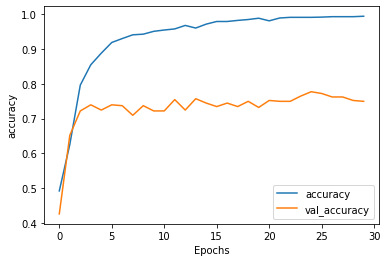

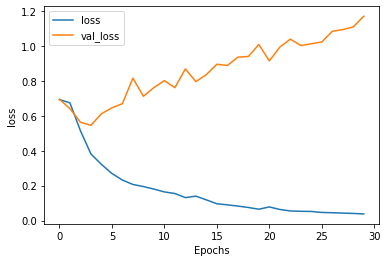

1/1 [==============================] - 1s 1s/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9929093]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.00378857]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.00551577]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything wa

In [15]:
embedding_dim = 16

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1,activation = "sigmoid")
])

# model_multiple_bidi_lstm.compile(loss = "categorical_crossentropy",optimizer = "Adam",metrics = ["accuracy"])
fit_model_and_results(model_multiple_bidi_lstm,fake_reviews)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
model_multiple_bidi_lstm.save('BLSTM_model1.h5')
print('Model Saved!')
 
# load model
from tensorflow.keras.models import load_model
savedModel=load_model('BLSTM_model1.h5')
savedModel.summary()